In [ ]:
!pip install google-cloud-automl
!apt-get install libmagickwand-dev
!pip install pillow
!pip install --upgrade protobuf
!pip install --upgrade google-cloud-videointelligence
!pip install ipython google-cloud-videointelligence==1.16.1

In [ ]:
import sys
import os
import json
import math

from google.colab import drive
from google.colab import auth
from google.colab import files

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.cloud.videointelligence import enums
from google.oauth2 import service_account


from sklearn.model_selection import train_test_split
from numpy import save
import pandas as pd
import numpy as np
from numpy import load
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from tensorflow import keras

import csv

In [ ]:
#Loading Google Drive
drive.mount('/content/drive')

In [ ]:
#Google Cloud Authentication
auth.authenticate_user()

In [ ]:
#Google Cloud Project parameters
project_id = 'project-195409'  #@param {type: "string"}
bucket = 'gs://umpirepose_bucket_v2' #@param {type: "string"}
service_account_name="dmml2v3" #@param {type: "string"}

In [ ]:
#project_id configuration
!gcloud config set project {project_id}
#Create a new bucket
!gsutil mb {bucket}
#Create service_account_name
!gcloud iam service-accounts create {service_account_name}
#Created a key to access this project
!gcloud iam service-accounts keys create ./key.json --iam-account {service_account_name}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

# Give your service account permission to access the API
!gcloud projects add-iam-policy-binding {project_id} --member="serviceAccount:{service_account_name}@{project_id}.iam.gserviceaccount.com" --role="roles/editor"

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

In [ ]:
#Create file names for two signals noball and out
obj_noball = {}
obj_out = {}
numbers = list(range(1,51,1))
for index in numbers:
  obj_noball["test_noball" + str(index)] = []
  obj_out["test_out" + str(index)] = []

In [ ]:
for keys in obj_noball.keys():
  file_to_analyze = keys + ".mp4" 
  input_uri = os.path.join(bucket, file_to_analyze)
  output_uri = os.path.join(bucket, keys+ '.json')

#This function is avaiable on "https://cloud.google.com/video-intelligence/docs/people-detection" to detect person in the video
  def detect_person(input_uri, output_uri):
      """Detects people in a video."""
      client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
      './key.json'))

      # Configure the request
      config = videointelligence.types.PersonDetectionConfig(
          include_bounding_boxes=True,
          include_attributes=True,
          include_pose_landmarks=True,
      )
      context = videointelligence.types.VideoContext(person_detection_config=config)

      # Start the asynchronous request
      operation = client.annotate_video(
          input_uri=input_uri,
          output_uri=output_uri,
          features=[enums.Feature.PERSON_DETECTION],
          video_context=context,
      )

      return operation
  operation = detect_person(input_uri, output_uri)
  !mkdir tmp2
  !gsutil cp {output_uri} tmp2

In [ ]:
for keys in obj_out.keys():
  file_to_analyze = keys + ".mp4" 
  input_uri = os.path.join(bucket, file_to_analyze)
  output_uri = os.path.join(bucket, keys+ '.json')

#This function is avaiable on "https://cloud.google.com/video-intelligence/docs/people-detection" to detect person in the video
  def detect_person(input_uri, output_uri):
      """Detects people in a video."""

      client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
      './key.json'))

      # Configure the request
      config = videointelligence.types.PersonDetectionConfig(
          include_bounding_boxes=True,
          include_attributes=True,
          include_pose_landmarks=True,
      )
      context = videointelligence.types.VideoContext(person_detection_config=config)

      # Start the asynchronous request
      operation = client.annotate_video(
          input_uri=input_uri,
          output_uri=output_uri,
          features=[enums.Feature.PERSON_DETECTION],
          video_context=context,
      )

      return operation
  operation = detect_person(input_uri, output_uri)
  !mkdir tmp2
  !gsutil cp {output_uri} tmp2

In [ ]:
#This function takes in a person and rearranges the data so it's in a timeline, which will make it easier for us to work with
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

In [ ]:
#Json file parsing and stored in dataframe
noball_Pd = pd.DataFrame([])
out_Pd = pd.DataFrame([])
for keys in obj_noball.keys():
  data = json.load(open('/content/tmp/' + keys + '.json'))
  people_annotations = data['annotation_results'][0]['person_detection_annotations']
  annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
  noball_Pd = noball_Pd.append(annotationsPd)
for keys in obj_out.keys():
  data = json.load(open('/content/tmp/' + keys + '.json'))
  people_annotations = data['annotation_results'][0]['person_detection_annotations']
  annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
  out_Pd = out_Pd.append(annotationsPd)
noball_Pd.to_csv(r'/content/noball_Pd.csv', index = False, header=True)
out_Pd.to_csv(r'/content/out_Pd.csv', index = False, header=True)

In [ ]:
#Check the NA's in the dataset
column_means = noball_Pd.mean()
noball_Pd.fillna(column_means, inplace=True)
column_means = out_Pd.mean()
out_Pd.fillna(column_means, inplace=True)

print(noball_Pd.isnull().values.any())
print(out_Pd.isnull().values.any())

False
False


In [ ]:
#Mostly upper body part cordinates will change so remving the lowe body part coordinates
noball_Pd.drop(['left_ankle_x', 'left_ankle_y', 'right_ankle_x','right_ankle_y','left_knee_x', 'left_knee_y', 'right_knee_x','right_knee_y'], axis = 1, inplace=True) 
#noball_Pd.drop(['left_knee_x', 'left_knee_y', 'right_knee_x','right_knee_y'], axis = 1, inplace=True) 
out_Pd.drop(['left_knee_x', 'left_knee_y', 'right_knee_x','right_knee_y'], axis = 1, inplace=True) 
#out_Pd.drop(['left_ankle_x', 'left_ankle_y', 'right_ankle_x','right_ankle_y','left_knee_x', 'left_knee_y', 'right_knee_x','right_knee_y'], axis = 1, inplace=True) 
print(noball_Pd)
print(out_Pd)

    timestamp    nose_x    nose_y  ...  left_hip_y  right_hip_x  right_hip_y
0         0.0  0.468204  0.845818  ...    0.389503     0.426430     0.393977
1         0.1  0.469055  0.852183  ...    0.386314     0.427625     0.386314
2         0.2  0.466370  0.852608  ...    0.392038     0.428696     0.392038
3         0.3  0.466311  0.850931  ...    0.387964     0.427712     0.383512
4         0.4  0.464404  0.852926  ...    0.391466     0.426298     0.387071
..        ...       ...       ...  ...         ...          ...          ...
26        2.6  0.486819  0.668361  ...    0.222033     0.429662     0.229174
27        2.7  0.484276  0.666302  ...    0.222535     0.429376     0.226113
28        2.8  0.484198  0.665778  ...    0.218785     0.429342     0.225937
29        2.9  0.484944  0.665427  ...    0.218670     0.430117     0.225818
30        3.0  0.481619  0.665694  ...    0.222333     0.429154     0.229484

[1401 rows x 27 columns]
    timestamp    nose_x    nose_y  ...  left_hip_y

In [ ]:
#Storing the copy of dataframe
no_test = noball_Pd.reset_index()
no_test.drop("index",axis=1,inplace=True)
out_test = out_Pd.reset_index()
out_test.drop("index",axis=1,inplace=True)
print(no_test)
print(out_test)

      timestamp    nose_x    nose_y  ...  left_hip_y  right_hip_x  right_hip_y
0           0.0  0.468204  0.845818  ...    0.389503     0.426430     0.393977
1           0.1  0.469055  0.852183  ...    0.386314     0.427625     0.386314
2           0.2  0.466370  0.852608  ...    0.392038     0.428696     0.392038
3           0.3  0.466311  0.850931  ...    0.387964     0.427712     0.383512
4           0.4  0.464404  0.852926  ...    0.391466     0.426298     0.387071
...         ...       ...       ...  ...         ...          ...          ...
1396        2.6  0.486819  0.668361  ...    0.222033     0.429662     0.229174
1397        2.7  0.484276  0.666302  ...    0.222535     0.429376     0.226113
1398        2.8  0.484198  0.665778  ...    0.218785     0.429342     0.225937
1399        2.9  0.484944  0.665427  ...    0.218670     0.430117     0.225818
1400        3.0  0.481619  0.665694  ...    0.222333     0.429154     0.229484

[1401 rows x 27 columns]
      timestamp    nose_x 

In [ ]:
#Creating a list which contains the starting index and ending video data index
zero_index_no = no_test[no_test["timestamp"]==0].index.to_list()  
#zero_index_n0_no =  zero_index_no[1:] 
zero_index_n0_no = []
for i in range(len(zero_index_no)):
  if (i>0):
    zero_index_n0_no.append(zero_index_no[i]+1)
zero_index_n0_no.append(len(no_test))
zero_index_out = out_test[out_test["timestamp"]==0].index.to_list()
#zero_index_n0_out =  zero_index_out[1:]
zero_index_n0_out = []
for i in range(len(zero_index_no)):
  if (i>0):
    zero_index_n0_out.append(zero_index_out[i]+1)
zero_index_n0_out.append(len(out_test))
print(zero_index_no)
print(zero_index_n0_no)
print(zero_index_out)
print(zero_index_n0_out)

[0, 35, 64, 93, 125, 155, 184, 211, 239, 266, 296, 321, 347, 372, 399, 422, 449, 474, 499, 527, 552, 577, 601, 625, 649, 677, 707, 727, 755, 782, 813, 842, 865, 896, 925, 958, 991, 1016, 1044, 1087, 1108, 1136, 1163, 1194, 1224, 1254, 1279, 1316, 1344, 1370]
[36, 65, 94, 126, 156, 185, 212, 240, 267, 297, 322, 348, 373, 400, 423, 450, 475, 500, 528, 553, 578, 602, 626, 650, 678, 708, 728, 756, 783, 814, 843, 866, 897, 926, 959, 992, 1017, 1045, 1088, 1109, 1137, 1164, 1195, 1225, 1255, 1280, 1317, 1345, 1371, 1401]
[0, 51, 97, 128, 162, 192, 223, 258, 289, 329, 358, 386, 423, 451, 480, 509, 538, 578, 615, 644, 674, 703, 733, 762, 789, 816, 847, 876, 905, 935, 962, 991, 1018, 1043, 1075, 1119, 1148, 1174, 1200, 1232, 1270, 1299, 1330, 1359, 1387, 1417, 1444, 1473, 1503, 1541]
[52, 98, 129, 163, 193, 224, 259, 290, 330, 359, 387, 424, 452, 481, 510, 539, 579, 616, 645, 675, 704, 734, 763, 790, 817, 848, 877, 906, 936, 963, 992, 1019, 1044, 1076, 1120, 1149, 1175, 1201, 1233, 1271, 1300, 

In [ ]:
#Dropping the timestamp from the dataframe
no_test = no_test.drop("timestamp",axis=1)
out_test = out_test.drop("timestamp",axis=1)

In [ ]:
#Every alternate video's data is subtracted from the previous videos data last frame data
for item, num in zip (zero_index_no,zero_index_n0_no):
  no_test.loc[item:num,:] = no_test.loc[item:num,:] - no_test.loc[item,:]
  print (no_test.loc[item:num,:])
for item, num in zip (zero_index_out,zero_index_n0_out):
    out_test.loc[item:num,:] = out_test.loc[item:num,:] - out_test.loc[item,:]
print(no_test)
print(out_test)

In [ ]:
#Stored in the dictionary 
noball = {}
out = {}
for index, num in zip(zero_index_no,zero_index_n0_no):
  noball["noball" + str(index)] = no_test.iloc[index:num,:]
for index, num in zip(zero_index_out,zero_index_n0_out):
  out["out" + str(index)] = out_test.iloc[index:num,:]

print(noball)
print(out)

In [ ]:
#Stored each record of no ball and out in the numpy array 
sequence_noball = []
sequence_out = []
for key in noball:
  sequence_noball.append(noball[key].values)
for key in out:
  sequence_out.append(out[key].values)
print("No ball")
print(sequence_noball[49])
print("Out")
print(sequence_out[49])

Length of sequences of no ball: 
44


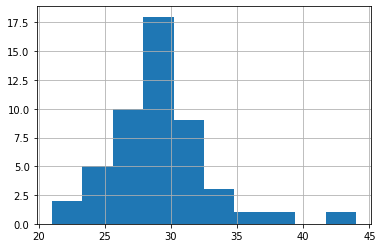

In [ ]:
#Plotting ferquency of length of sequences of no ball 
len_sequences = []
for one_seq in sequence_noball:
    len_sequences.append(len(one_seq))
print("Length of sequences of no ball: ")
print (max(len_sequences))
pd.Series(len_sequences).hist()

Length of sequences of out: 
52


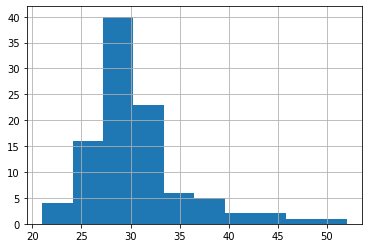

In [ ]:
#Plotting ferquency of length of sequences of out
for one_seq in sequence_out:
    len_sequences.append(len(one_seq))
print("Length of sequences of out: ")
print (max(len_sequences))
pd.Series(len_sequences).hist()

In [ ]:
#Padding the sequence with the values in last row to max length
to_pad = 44
#to_pad = 35
new_seq = []
for one_seq in sequence_noball:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(26, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_noball = np.stack(new_seq)

#truncate the sequence to length 24
from keras.preprocessing import sequence
seq_len = 24
final_seq_noball=sequence.pad_sequences(final_seq_noball, maxlen=seq_len, padding='post', dtype='float', truncating='pre')
print(final_seq_noball)

In [ ]:
#Padding the sequence with the values in last row to max length
to_pad = 52
#to_pad = 35
new_seq = []
for one_seq in sequence_out:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(26, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_out = np.stack(new_seq)
#truncate the sequence to length 24
from keras.preprocessing import sequence
seq_len = 24
final_seq_out=sequence.pad_sequences(final_seq_out, maxlen=seq_len, padding='post', dtype='float', truncating='pre')
print(final_seq_out)

In [ ]:
#Labels
noball_label = ["No Ball"]*50
out_label = ["Out"]*50
label_data = noball_label + out_label 
len(label_data)

100

In [ ]:
#Final sequence of no ball and out
final_seq_noball = np.array(final_seq_noball)
final_seq_out = np.array(final_seq_out)
print(final_seq_noball.shape)
print(final_seq_out.shape)

(50, 24, 26)
(50, 24, 26)


In [ ]:
#Stacking the sequence of noball and out 
final_seq_train = np.vstack((final_seq_noball,final_seq_out))
final_seq_train.shape

(100, 24, 26)

In [ ]:
#Splitting the data for training
x_train,x_test,y_train,y_test = train_test_split(final_seq_train,label_data,test_size = 0.25,random_state=2)

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

75
25
75
25


In [ ]:
#Saved train and tes data
save("x_train",x_train)
save("x_test",x_test)
save("y_train",y_train)
save("y_test",y_test)

In [ ]:
np.save("classify_this",final_seq_train)

In [ ]:
#Loading train and test data
x_train = load("x_train.npy")
y_train = load("y_train.npy")
x_test = load("x_test.npy")
y_test = load("y_test.npy")

In [ ]:
#Encoding of labels 
print(y_train[0])
print(y_test[0])
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
print(y_train[0])
print(y_test[0])

No Ball
Out
0
1


In [ ]:
#LST Model
model = Sequential()
model.add(LSTM(32,activation="tanh",input_shape = (24,26),return_sequences=True))
model.add(Dropout(0.30))
model.add(LSTM(32))
model.add(Dense(2,activation="softmax"))

In [ ]:
#Model paramters 
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
#Training the model
training = model.fit(x_train,y_train,epochs=5, batch_size=1,validation_split=0.25,verbose=1)
history = training.history

Epoch 1/5
56/56 [==============================] - 6s 41ms/step - loss: 0.6908 - accuracy: 0.6113 - val_loss: 0.6893 - val_accuracy: 0.4211
Epoch 2/5
56/56 [==============================] - 1s 17ms/step - loss: 0.5694 - accuracy: 0.8339 - val_loss: 0.4863 - val_accuracy: 0.8421
Epoch 3/5
56/56 [==============================] - 1s 25ms/step - loss: 0.4334 - accuracy: 0.8042 - val_loss: 0.4271 - val_accuracy: 0.8947
Epoch 4/5
56/56 [==============================] - 1s 25ms/step - loss: 0.2101 - accuracy: 0.9320 - val_loss: 0.3785 - val_accuracy: 0.8421
Epoch 5/5
56/56 [==============================] - 1s 20ms/step - loss: 0.3016 - accuracy: 0.8315 - val_loss: 0.4026 - val_accuracy: 0.8421


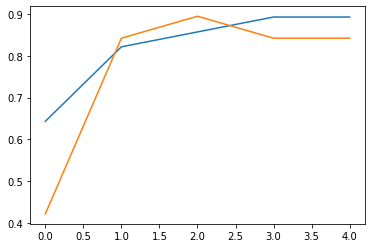

In [ ]:
#Training and Validation Accuracy Plot
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

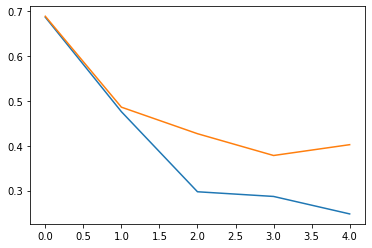

In [ ]:
#Training and Validation Loss Plot
plt.plot(history["loss"])
plt.plot(history["val_loss"])